In [8]:
import pandas as pd
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
from loguru import logger

In [9]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
os.chdir(os.environ.get("ROOT_DIR"))
from src import DATA_DIR
raw_data_dir = DATA_DIR / 'raw'

In [10]:
# if import is 0 it reads the data from the existing file
# otherwise reads in the raw data an makes a unified dataset
IMPORT = 0 

In [11]:
# Read in all patterns files in the monthly-patterns folder
def get_files():
    patterns_path = raw_data_dir / "monthly-patterns"
    files = []
    for f in patterns_path.glob("**/*.csv.gz"):
        files.append(f)
    return files

In [12]:
def filter_to_philly(df):
    # zip codes are read as integers rather than strings so we add leading zeros.
    # this is not strictly necessary since Philadelphia zipcodes don't have leading zeros.
    
    # Philadelphia selection
    # HK: adding leading zeros because some zipcodes in MA are 0191X.
    df['postal_code'] = df['postal_code'].apply(lambda x: ('00000'+str(x))[-5:])
    in_philly = df['postal_code'].astype(str).str.startswith("191")
    df = df.loc[in_philly]
    df = df[['safegraph_place_id','date_range_start','postal_code', 
             'raw_visit_counts', 'raw_visitor_counts']]
    
    return df

In [19]:
if IMPORT == 1:
    philly_patterns = []
    files = get_files()
    for i, f in enumerate(files):
        print(f)
        philly_patterns.append(filter_to_philly(pd.read_csv(f)))
    philly_patterns = pd.concat(philly_patterns)
    philly_patterns.to_csv(
    DATA_DIR / "processed" / "kmeans_patterns.csv.tar.gz", index=False
    )
else:
    philly_patterns = pd.read_csv(DATA_DIR / "processed" / "philly_patterns.csv.tar.gz", low_memory = False)

In [20]:
philly_patterns.columns

Index(['placekey_x', 'safegraph_place_id', 'location_name_x',
       'street_address_x', 'city_x', 'region_x', 'postal_code_x',
       'safegraph_brand_ids_x', 'brands_x', 'date_range_start',
       'date_range_end', 'raw_visit_counts', 'raw_visitor_counts',
       'visits_by_day', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_work_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'parent_safegraph_place_id', 'location_name_y',
       'safegraph_brand_ids_y', 'brands_y', 'top_category', 'sub_category',
       'naics_code', 'latitude', 'longitude', 'street_address_y', 'city_y',
       'region_y', 'postal_code_y', 'iso_country_code', 'phone_number',
       'open_hours', 'category_tags', 'valid_to', 'valid_from', 'placekey_y',
       'opened_on', 'closed_on', 'tracking_opened_since',
 

In [21]:
philly_patterns= philly_patterns[['safegraph_place_id','date_range_start', 
             'raw_visit_counts', 'raw_visitor_counts', 'poi_cbg','top_category']]
philly_patterns['poi_cbg'] = philly_patterns['poi_cbg'].astype(int)

In [22]:
census_path = DATA_DIR / 'raw' / 'open-census-data'
files = [file for file in census_path.glob('**/cbg_b19.csv')]
census = pd.read_csv(files[0])
census =  census[['census_block_group','B19013e1']]

In [23]:
philly_patterns = philly_patterns.merge(census, left_on = 'poi_cbg', right_on = 'census_block_group', how = 'left')
philly_patterns.drop(columns = 'census_block_group', inplace = True)

In [24]:
philly_patterns['income_missing'] = philly_patterns['B19013e1'].isna().astype(int)
philly_patterns['B19013e1'].fillna(value=philly_patterns['B19013e1'].mean(), inplace=True)

In [25]:
philly_patterns.tail()

,safegraph_place_id,date_range_start,raw_visit_counts,raw_visitor_counts,poi_cbg,top_category,B19013e1,income_missing
366386,sg:80c76cec2da64dcdb50027f13529dbb3,2020-01-01,214,132,421010340003,Gasoline Stations,44063.000000,0
366387,sg:9069d8f6da3243efb302d8db9f27f808,2020-01-01,104,49,421010037014,Religious Organizations,38008.000000,0
366388,sg:97506be6df9e42a8b90dcc3c6fed19d5,2020-01-01,4,3,421010385002,Other Schools and Instruction,62448.000000,0
366389,sg:ad30d9221c424b768e4f56a4f7a559f2,2020-01-01,426,314,421019809001,"Automotive Parts, Accessories, and Tire Stores",49178.073953,1
366390,sg:c3022009242f48d6b744b49e49c61ada,2020-01-01,764,180,421010170003,Other Amusement and Recreation Industries,27361.000000,0


In [26]:
check = philly_patterns.groupby(['safegraph_place_id']).nunique()

In [27]:
check.loc[check['B19013e1']>1]

,date_range_start,raw_visit_counts,raw_visitor_counts,poi_cbg,top_category,B19013e1,income_missing
safegraph_place_id,,,,,,,
sg:002e331cebec461d932e13cee0e01ca3,22,22,22,2,1,2,2
sg:01243aca691a4d8aadc71508c7f896d8,22,22,22,2,1,2,1
sg:013cf0b60e5a4378a892ef817ca237eb,21,21,19,2,1,2,1
sg:02e29d67ea1f49cc8767944cc5d3f753,17,17,17,2,1,2,1
sg:04872a5751b44249a680c0b2da950d07,22,22,20,2,2,2,1
...,...,...,...,...,...,...,...
sg:f56498354f1a4808a8208cb2b92449d4,22,20,21,2,1,2,1
sg:f6e8bff739e74b388b3ceae8d6e32201,22,22,22,2,1,2,1
sg:f96c8176707546c58fae32ab615b4149,21,12,12,2,1,2,1


In [28]:
philly_patterns[philly_patterns['safegraph_place_id'] == 'sg:002e331cebec461d932e13cee0e01ca3']

,safegraph_place_id,date_range_start,raw_visit_counts,raw_visitor_counts,poi_cbg,top_category,B19013e1,income_missing
6560,sg:002e331cebec461d932e13cee0e01ca3,2020-10-01,1651,704,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
23543,sg:002e331cebec461d932e13cee0e01ca3,2020-09-01,1872,768,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
38761,sg:002e331cebec461d932e13cee0e01ca3,2020-06-01,564,360,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
64006,sg:002e331cebec461d932e13cee0e01ca3,2020-08-01,1600,772,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
75944,sg:002e331cebec461d932e13cee0e01ca3,2020-07-01,1234,555,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
86819,sg:002e331cebec461d932e13cee0e01ca3,2020-05-01,372,203,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
103484,sg:002e331cebec461d932e13cee0e01ca3,2019-03-01,666,343,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
120696,sg:002e331cebec461d932e13cee0e01ca3,2019-04-01,1019,483,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
141622,sg:002e331cebec461d932e13cee0e01ca3,2019-05-01,945,427,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
158528,sg:002e331cebec461d932e13cee0e01ca3,2019-02-01,484,218,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1


In [49]:
philly_patterns['date_range_start'] = philly_patterns['date_range_start'].apply(lambda x : x[:10])
mask = philly_patterns['date_range_start'] < '2020-03-01' 
prepandemic = philly_patterns.loc[mask,].copy()
pandemic = philly_patterns.loc[~mask,].copy()

In [50]:
prepandemic.date_range_start.unique()

array(['2019-03-01', '2019-04-01', '2019-05-01', '2019-02-01',
       '2019-11-01', '2019-10-01', '2019-07-01', '2019-09-01',
       '2019-08-01', '2019-01-01', '2019-06-01', '2019-12-01',
       '2020-02-01', '2020-01-01'], dtype=object)

In [51]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [52]:
def cut_outliers(df):
    for col in ['raw_visit_counts', 'raw_visitor_counts']:
        ub = 2*df[col].quantile(0.99)
        mask = df[col] > ub
        df.loc[mask,col] = ub
    return df

def make_dummies(df, cols):
    return pd.get_dummies(df)
    

def Stdrshp(df, pivot_cols, constant_cols): 
    constant = df.loc[
        df.groupby('safegraph_place_id').cumcount() == 0,
        ['safegraph_place_id']+constant_cols
    ]
    constant.set_index('safegraph_place_id', inplace = True)
    constant = make_dummies(constant, pivot_cols)
    pivoted = df.pivot(index='safegraph_place_id',columns='date_range_start')[pivot_cols]
    new_cols = [('{1} {0}'.format(*tup)) for tup in pivoted.columns]
    pivoted.columns = new_cols
    df = pivoted.join(constant)
    df = df.fillna(0)
    scaled = StandardScaler().fit_transform(df)
    scaled_features_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
    return scaled_features_df

def make_clusters(df, k = 5):
    kmeans = KMeans(n_clusters=k).fit(df)
    df['cluster'] = kmeans.labels_
    return (df, kmeans.inertia_)

def run_Kmeans(df, pivot_cols, constant_cols, k = 5):
    normalized = Stdrshp(cut_outliers(df), pivot_cols, constant_cols)
    return make_clusters(normalized, k)

In [53]:
pivot_cols = ['raw_visit_counts', 'raw_visitor_counts']
constant_cols = ['B19013e1','income_missing','top_category']

In [54]:
scaled = Stdrshp(cut_outliers(prepandemic), pivot_cols, constant_cols)
n_clusters = [k for k in range(3,13)]
inertias = []
for k in n_clusters:
    df, inertia = make_clusters(scaled, k = k)
    inertias.append(inertia)

In [55]:
scaled.head()

,2019-01-01 raw_visit_counts,2019-02-01 raw_visit_counts,2019-03-01 raw_visit_counts,2019-04-01 raw_visit_counts,2019-05-01 raw_visit_counts,2019-06-01 raw_visit_counts,2019-07-01 raw_visit_counts,2019-08-01 raw_visit_counts,2019-09-01 raw_visit_counts,2019-10-01 raw_visit_counts,...,top_category_Support Activities for Road Transportation,top_category_Taxi and Limousine Service,top_category_Technical and Trade Schools,top_category_Travel Arrangement and Reservation Services,top_category_Traveler Accommodation,top_category_Used Merchandise Stores,top_category_Warehousing and Storage,top_category_Waste Treatment and Disposal,top_category_Wired and Wireless Telecommunications Carriers,cluster
safegraph_place_id,,,,,,,,,,,,,,,,,,,,,
sg:00018e7b1ba449278dd1c33a2348e5fa,-0.308397,-0.283839,-0.389244,-0.421188,-0.343016,-0.370347,-0.365453,-0.357736,-0.355670,-0.382528,...,-0.056516,-0.016569,-0.020961,-0.019606,-0.094724,-0.086406,-0.007409,-0.043242,-0.104558,0
sg:0001da921b9d488986c0bdf83bfaff4b,-0.380360,-0.396185,-0.417387,-0.404297,-0.424432,-0.424263,-0.418817,-0.400218,-0.456967,-0.473416,...,-0.056516,-0.016569,-0.020961,-0.019606,-0.094724,-0.086406,-0.007409,-0.043242,-0.104558,0
sg:0003e5a379604393b0dc6e9bce0058b2,-0.149322,-0.140183,-0.102529,-0.112077,-0.107429,-0.139281,-0.127368,-0.087391,-0.147926,-0.164776,...,-0.056516,-0.016569,-0.020961,-0.019606,-0.094724,-0.086406,-0.007409,-0.043242,-0.104558,10
sg:0004189674c64e108e4b5ea2baa68eb9,-0.418235,-0.366717,-0.408592,-0.424567,-0.398448,-0.397305,-0.406502,-0.415667,-0.407177,-0.427972,...,-0.056516,-0.016569,-0.020961,-0.019606,-0.094724,-0.086406,-0.007409,-0.043242,-0.104558,0
sg:0008547f38f54091836959120205256c,1.348637,1.217180,1.009148,1.070318,1.959149,1.010276,0.790080,0.725575,0.921700,0.764931,...,-0.056516,-0.016569,-0.020961,-0.019606,-0.094724,-0.086406,-0.007409,-0.043242,-0.104558,3


In [56]:
import matplotlib.pyplot as plt

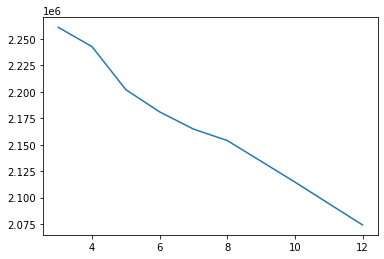

In [57]:
plt.plot(n_clusters,inertias)

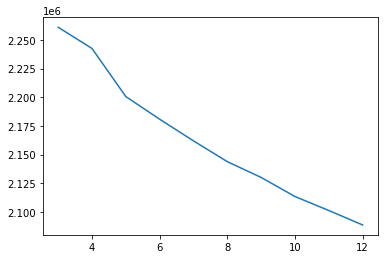

In [58]:
scaled = Stdrshp(prepandemic, pivot_cols, constant_cols)
n_clusters = [k for k in range(3,13)]
inertias = []
for k in n_clusters:
    df, inertia = make_clusters(scaled, k = k)
    inertias.append(inertia)
    
plt.plot(n_clusters,inertias)

In [59]:
prepandemic, prepandemic_inertia = run_Kmeans(prepandemic, pivot_cols, constant_cols, k = 5)
pandemic, pandemic_inertia = run_Kmeans(pandemic, pivot_cols, constant_cols, k = 5)

In [60]:
pandemic_inertia

2982904.9242658

In [61]:
# We want to compare pandemic_inertia to the inertia we would have in 2020 if we used the
# 2019 clustering
combined = pandemic.join(prepandemic[['cluster']], how='left',rsuffix='pre')
combined[['clusterpre']] = combined[['clusterpre']].fillna(value=-1)
combined['clusterpre'] = combined['clusterpre'].astype(int)

In [62]:
cols = combined.columns
cols = cols[:-2]
n = len(combined.columns)

In [63]:
def get_inertia(df, cols, cluster_col):
    mask = df[cluster_col] > -1
    n = len(df.index)
    filtered = df[mask]
    m = len(filtered.index)
    se = ((df[cols] - df.groupby(cluster_col)[cols].transform('mean'))**2).to_numpy().sum()
    return se*(n/m)

get_inertia(combined, cols, 'clusterpre')

3481289.1333563984

In [64]:
#worst case scenario
combined['newcol'] = 1
get_inertia(combined, cols, 'newcol')

3231360.000000001

In [65]:
combined.groupby('cluster').size()

cluster
0       28
1    16925
2      173
3     3054
4       16
dtype: int64

In [66]:
combined.groupby('clusterpre').size()

clusterpre
-1     2407
 0     4305
 1    12453
 2      118
 3      335
 4      578
dtype: int64